# Data Wrangling | Twitter | HK NLP Project

# Table of Contents
* [1.0 Wrangling](#toc)
  * [1.1 Contents](#wrangle_contents)
  * [1.2 Imports & Set Up](#imports)
  * [1.3 Initial Scraping before Regex](#int_scrape)
  * [1.4 Regex](#regex)
     * [1.4.1 Duplicated TorF](#dupe)
     * [1.4.2 Language](#lang)
     * [1.4.3 Mentions to Other Users](#oum)
     * [1.4.4 HTML tags](#htmltags)
     * [1.4.5 Emoji's](#emojis)
     * [1.4.6 Profanity](#profanity)
     * [1.4.7 Foreign Languages](#flanguage)
     * [1.4.8 Sentiment Intensity Analyzer](#sia)
     * [1.4.9 Stop Words](#stop_words) 
     * [1.4.10 Stemming](#word_stem) 
     * [1.4.11 Lemmatization](#word_lem) 
     * [1.4.12 Tweet Length](#tweet_length) 
     * [1.4.13 Number of Hashtags](#num_hashtags) 
     * [1.4.14 TfidfVectorizer](#word_v_tfid) 
     * [1.4.15 CountVectorizer](#word_v_count) 
  * [1.5 Putting the Data to the Side](#pts)


# **1.1 Contents**<a id='wrangle_contents'></a>

This is where you will summarize your intent. Mention you used `twint`

# **1.2 Imports & Set Up**<a id='imports'></a>

In [1]:
# Main Imports
import os
import sys
import numpy as np
import statistics
from scipy import stats
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
%matplotlib inline
import datetime
import warnings
warnings.filterwarnings("ignore")
%reload_ext watermark
from translate import translator
import googletrans
from googletrans import Translator

# NLP Imports
import re
import string
import nltk
import pickle
import emoji
from better_profanity import profanity
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter
import spacy
nltk.download("stopwords")
stop = stopwords.words('english')
stopwords = nltk.corpus.stopwords.words('english')
ps= nltk.PorterStemmer()

results = Counter()

# from polyglot.text import Text

# The below 2 may be required
# import nltk
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

# Still importing twint
import twint
import nest_asyncio
nest_asyncio.apply()

%watermark -d -t -v -p pandas

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rands\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pandas: 1.2.4



In [3]:
cd

C:\Users\rands


In [4]:
df = pd.read_excel('./_Capstone_Two_NLP/data/_twitter/tweets.xlsx')
df = df.reset_index()
df = df.drop(columns=['Unnamed: 0','index'])

# **1.3 Initial Scraping before Regex**<a id='int_scrape'></a>

In [5]:
df.head(2)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28 10:23:06 Eastern Daylight Time,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-27 11:15:39 Eastern Daylight Time,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."


In [6]:
len(df)

288416

In [7]:
df.shape

(288416, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288416 entries, 0 to 288415
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   hash            288416 non-null  object
 1   created_at      288416 non-null  object
 2   username        288416 non-null  object
 3   tweet           288416 non-null  object
 4   language        288416 non-null  object
 5   replies_count   288416 non-null  int64 
 6   retweets_count  288416 non-null  int64 
 7   likes_count     288416 non-null  int64 
 8   reply_to        288416 non-null  object
 9   hashtags        288416 non-null  object
dtypes: int64(3), object(7)
memory usage: 22.0+ MB


In [9]:
#this is confirmed above but will double confirm
df.isnull().values.any()

False

**Data Defined**

In this short section, we will highlight what the columns are referring too.

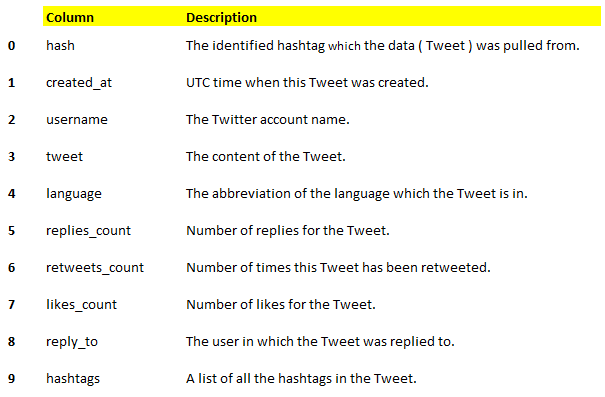

In [10]:
#Range of values per column
df.agg([min,max]).T

,min,max
hash,#FightForHongKong,#standwithhongkong
created_at,2020-05-31 20:01:47 Eastern Daylight Time,2020-08-29 19:59:41 Eastern Daylight Time
username,0007_rakeshrai,zzzzz78395655
tweet,"https://t.co/00NUHE1cdc It would help, moving...",🪔1989 #TiananmenMassacre VIGIL🪔 #FightForFreed...
language,ar,zh
replies_count,0,3014
retweets_count,0,16023
likes_count,0,41413
reply_to,[],"[{'screen_name': 'zz_obey', 'name': 'MiMiMA.K'..."
hashtags,"['01july2020', 'internetvideo', 'hkpolicebruta...",[]


In [11]:
#Checking for nulls
df.isnull().sum()

hash              0
created_at        0
username          0
tweet             0
language          0
replies_count     0
retweets_count    0
likes_count       0
reply_to          0
hashtags          0
dtype: int64

In [12]:
#Checking the datatypes
df.dtypes

hash              object
created_at        object
username          object
tweet             object
language          object
replies_count      int64
retweets_count     int64
likes_count        int64
reply_to          object
hashtags          object
dtype: object

The `created_at` column is an object; I will convert it to `datetime`.

In [13]:
new_date = df['created_at']
new_date = new_date.str.split(expand=True)
new_date = new_date[0]
new_date = pd.to_datetime(new_date)

In [14]:
df['created_at'] = new_date
df.head(2)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-27,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."


In [15]:
# df.dtypes

In [16]:
#count of unique values for every column, regardless of data type
df.nunique()

hash                  12
created_at            91
username           45111
tweet             221205
language              51
replies_count        217
retweets_count       881
likes_count         1110
reply_to           27555
hashtags           77715
dtype: int64

The `hash` number looks correct as that's how many hashtags were pulled.

In [17]:
df['hash'].unique()

array(['#FightForHongKong', '#HongKongProtest', '#PrayForHongkong',
       '#WeAreNotAlone', '#nochinaextradition', '#standwithhongkong',
       '#hkprotests', '#freehongkong', '#hkpolicebrutality',
       '#hkpolicestate', '#HKpoliceterrorist', '#hkpoliceterrorism'],
      dtype=object)

The `created_at` number also looks correct as **3 months after the implimentation of the law was the range in which the tweets were pulled** .

In [18]:
print('  ',df['created_at'].min(), ' | Beginning', '\n',
     ' ',df['created_at'].max(), ' | End')

   2020-05-31 00:00:00  | Beginning 
   2020-08-29 00:00:00  | End


The `username` number also makes sense.

In [19]:
print('A single user on average tweeted',round(len(df) / len(df['username'].unique()),0), 'times in the course of 3 months.')

A single user on average tweeted 6.0 times in the course of 3 months.


Most of the others aren't important but I believe **the `tweet` number should align with the length of the data frame to ensure there are no duplicates.**

In [20]:
print('There may be', "{:,}".format(len(df) - len(df['tweet'].unique())), 'duplicates to look into.')

There may be 67,211 duplicates to look into.


We will take a **look at where duplicates** may be found with the **`tweet` column**. Our initial focus is on **when a "tweeter"** (also known a person) **used multiple hashtags**.

A seperate data frame will be used to ensure the original is not compromised.

In [21]:
df_tweets = df.copy()
df_tweets = pd.DataFrame(df_tweets)
len(df_tweets)

288416

In [22]:
duplicated_tf = df_tweets.duplicated(subset=['tweet'])
duplicated_tf = pd.DataFrame(duplicated_tf)
len(duplicated_tf)

288416

In [23]:
duplicated_tf.columns = ['Duplicated']
duplicated_tf.tail(3)

,Duplicated
288413,False
288414,False
288415,True


In [24]:
num = {True:1,False:0}
duplicated_tf['Duplicated_TorF'] = duplicated_tf['Duplicated'].map(num)
duplicated_tf.tail(3)

,Duplicated,Duplicated_TorF
288413,False,0
288414,False,0
288415,True,1


In [25]:
duplicated_tf = duplicated_tf.drop(columns=['Duplicated'])

In [26]:
df_tweets_w_dup = pd.concat([df_tweets,duplicated_tf],
                    axis = 1, ignore_index=False)
df_tweets_w_dup = df_tweets_w_dup.reset_index(drop=True)

In [27]:
df_tweets_w_dup.tail(2)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
288414,#hkpoliceterrorism,2020-05-31,bluedreamsplan2,@OzraeliAvi China try hard to link up the #Min...,en,0,0,1,"[{'screen_name': 'OzraeliAvi', 'name': 'Avi Ye...","['minnesotariots', 'hongkongprotests', 'minnia...",0
288415,#hkpoliceterrorism,2020-05-31,jack83352493,#HongKongProtest #StandwithHK #HKPoliceTerrori...,und,0,0,0,[],"['hongkongprotest', 'standwithhk', 'hkpolicete...",1


In [28]:
print(' Ensuring we have the same # of tweets after classification.','\n', 
      round((( ( len(df_tweets_w_dup) / len(df) ) - 1 ) * 100)), '| This should be a Zero change','\n',
     df_tweets_w_dup['Duplicated_TorF'].nunique(), '| The Duplicated Column should have 2 unique values 0,1')

 Ensuring we have the same # of tweets after classification. 
 0 | This should be a Zero change 
 2 | The Duplicated Column should have 2 unique values 0,1


Ok. Let's take a quick look at some of these duplicates.

In [29]:
len(df_tweets_w_dup)

288416

In [30]:
df_tweets_w_dup.loc[df_tweets_w_dup['Duplicated_TorF'] == 1].sort_values(by=['tweet'])

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
240604,#freehongkong,2020-06-28,lilacrhk,https://t.co/01A6CwhNfM #standardwithHK #Sta...,und,0,0,0,[],"['standardwithhk', 'standwithhongkong', 'freeh...",1
176495,#hkprotests,2020-06-20,jjjlll,https://t.co/1EqQV5LDL5 #HongKong #HKProtests...,und,0,0,2,[],"['hongkong', 'hkprotests', 'fightforfreedom', ...",1
261737,#hkpolicebrutality,2020-06-13,1238cheng,https://t.co/1kz5fmNGWx #StandWithHongKong #...,en,0,0,0,[],"['standwithhongkong', 'hkpolicebrutality']",1
174843,#hkprotests,2020-08-29,ksin1984,https://t.co/2FxZRKLRuf #save12hkyouth #Stan...,und,0,1,3,[],"['save12hkyouth', 'standwithhongkong', 'hkprot...",1
211971,#freehongkong,2020-07-17,lilacrhk,https://t.co/2Gao97jVzl #StandWithHongKong #...,und,0,0,0,[],"['standwithhongkong', 'standwithhk', 'freehong...",1
...,...,...,...,...,...,...,...,...,...,...,...
216138,#freehongkong,2020-07-13,oneeyeh,🤬🤬🤬🤬😭😭😭 #FreeHongKong #StandWithHongKong ht...,und,0,0,0,[],"['freehongkong', 'standwithhongkong']",1
280873,#hkpolicestate,2020-06-12,can_johnhk,🤯That’s just insane. He obviously thinks #Blac...,en,0,0,0,[],"['blacklivesmatter', 'hkpolicebrutality', 'hkp...",1
236528,#freehongkong,2020-07-01,nick86544272,🥂 #FreeHongKong #StandWithHongKong https://t...,und,0,0,0,[],"['freehongkong', 'standwithhongkong']",1
198442,#freehongkong,2020-08-07,kvckelvin123,🥲 #Policebruatlity #StandWithHongKong #FreeHon...,und,0,0,0,[],"['policebruatlity', 'standwithhongkong', 'free...",1


In [31]:
len(df_tweets_w_dup)

288416

I would now like to **investigate the languages herein.**

<AxesSubplot:xlabel='Language Abbrevation', ylabel='# of observed Tweets'>

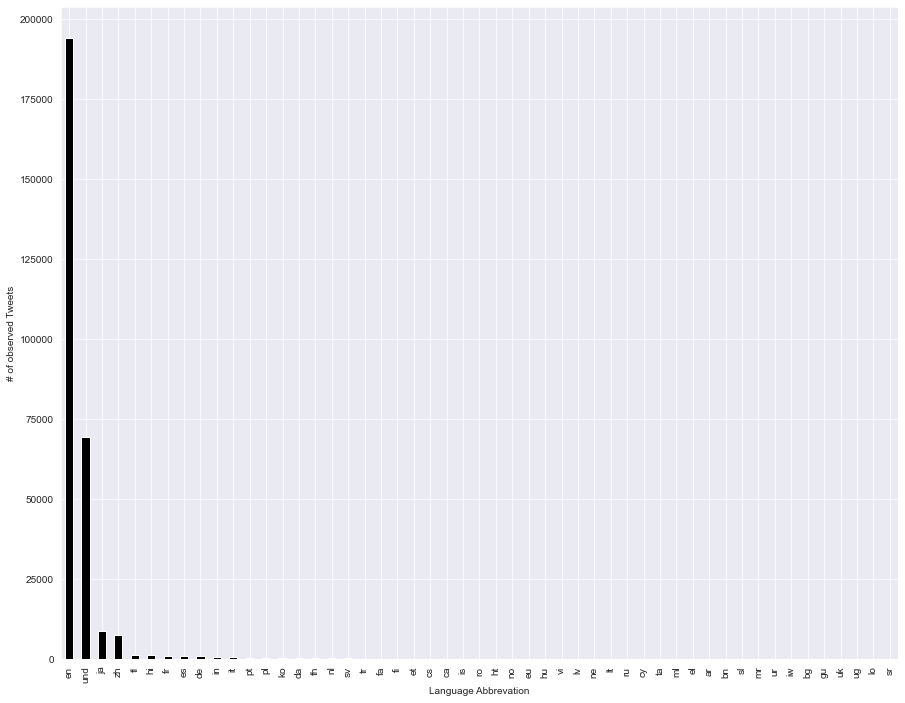

In [32]:
sns.set_style('darkgrid')
lang = pd.value_counts(df_tweets_w_dup['language'].values, sort=True)
lang = lang.sort_values(ascending=False)
plt.subplots(figsize=(15, 12))
plt.ylabel('# of observed Tweets')
plt.xlabel('Language Abbrevation')
lang.plot.bar(color='black')

In [33]:
df_tweets_w_dup['language'].value_counts().head(10)

en     194087
und     69375
ja       8715
zh       7327
tl       1254
hi       1207
fr       1046
es        908
de        892
in        507
Name: language, dtype: int64

In [34]:
lang_count = df_tweets_w_dup['language']
round(lang_count.value_counts(normalize=True),2).head()

en     0.67
und    0.24
ja     0.03
zh     0.03
tl     0.00
Name: language, dtype: float64

**`en` & `und` is contributing 91%. While `zh`'s (Mandarin Chinese) contribution is only 3%, Mandarin Chinese is important; I will unfortunately have to pass as 3% is unlikely to move the analysis outcome.**

**`und` refers to unknown. I am unsure as to what implications removing would do. Let's see what is "unknown".**

In [35]:
df.reset_index(drop=True)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-27,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."
2,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
3,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
4,#FightForHongKong,2020-08-24,cipopolitik,War or communism? https://t.co/V2kQTvR2wr #...,en,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf..."
...,...,...,...,...,...,...,...,...,...,...
288411,#hkpoliceterrorism,2020-06-01,bluedreamsplan2,Don't fall into the trap! #HKPoliceTerrorism #...,en,0,0,0,[],"['hkpoliceterrorism', 'hongkongpolicestate', '..."
288412,#hkpoliceterrorism,2020-06-01,villafish129,@KingJames #AllLivesMatters . #PoliceBrutality...,en,0,0,0,"[{'screen_name': 'KingJames', 'name': 'LeBron ...","['alllivesmatters', 'policebrutality', 'police..."
288413,#hkpoliceterrorism,2020-05-31,dingdin34098358,@ajphelo @HK55020097 The HK police killed a So...,en,0,1,1,"[{'screen_name': 'ajphelo', 'name': 'Andrew J ...","['policebrutality', 'hkpoliceterrorism']"
288414,#hkpoliceterrorism,2020-05-31,bluedreamsplan2,@OzraeliAvi China try hard to link up the #Min...,en,0,0,1,"[{'screen_name': 'OzraeliAvi', 'name': 'Avi Ye...","['minnesotariots', 'hongkongprotests', 'minnia..."


In [36]:
df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet'].head()

9      https://t.co/8lgfzmGtav   #lukashenko #Tikhan...
17    #FreeAgness #FightForFreedom #StandWithHongKon...
18    #Hongkongers  #hongkong #beijing #china #HongK...
20    #boycottchina #hongkong #freehk #boycottmulan ...
21     https://t.co/B5KWeYZE6t #boycottchina #hongko...
Name: tweet, dtype: object

In [37]:
df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet']

9          https://t.co/8lgfzmGtav   #lukashenko #Tikhan...
17        #FreeAgness #FightForFreedom #StandWithHongKon...
18        #Hongkongers  #hongkong #beijing #china #HongK...
20        #boycottchina #hongkong #freehk #boycottmulan ...
21         https://t.co/B5KWeYZE6t #boycottchina #hongko...
                                ...                        
288397    #HKPoliceState  #HKPoliceBrutality #HKTotalita...
288402         @IndyWorld #HKPoliceState #HKPoliceTerrorism
288406    #香港警暴 #港警是施虐者 #hkpolicebrutality #HKPoliceTerr...
288408    @SpokespersonCHN #ICantBreathe #Icannotbreathe...
288415    #HongKongProtest #StandwithHK #HKPoliceTerrori...
Name: tweet, Length: 69375, dtype: object

In [38]:
# df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet'][21]

In [39]:
# df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet'][39]

These appear to be tweets with **only hashtags**; while that may be important & it's contribution is large, **this excerise pertains to the text.**

**Further investigation may be required** at a later date but for now, **we will unfortunately drop them as well & only keep `en`.**

In [40]:
df_tweets_w_dup_en = df_tweets_w_dup[df_tweets_w_dup['language'].str.contains("en")]

In [41]:
df_tweets_w_dup_en.tail()

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
288410,#hkpoliceterrorism,2020-06-01,andrewhe2,@SpokespersonCHN Ms Hua please help them. #ICa...,en,0,0,0,"[{'screen_name': 'SpokespersonCHN', 'name': 'H...","['icantbreathe', 'icantbreath', 'icantbreathea...",1
288411,#hkpoliceterrorism,2020-06-01,bluedreamsplan2,Don't fall into the trap! #HKPoliceTerrorism #...,en,0,0,0,[],"['hkpoliceterrorism', 'hongkongpolicestate', '...",0
288412,#hkpoliceterrorism,2020-06-01,villafish129,@KingJames #AllLivesMatters . #PoliceBrutality...,en,0,0,0,"[{'screen_name': 'KingJames', 'name': 'LeBron ...","['alllivesmatters', 'policebrutality', 'police...",1
288413,#hkpoliceterrorism,2020-05-31,dingdin34098358,@ajphelo @HK55020097 The HK police killed a So...,en,0,1,1,"[{'screen_name': 'ajphelo', 'name': 'Andrew J ...","['policebrutality', 'hkpoliceterrorism']",0
288414,#hkpoliceterrorism,2020-05-31,bluedreamsplan2,@OzraeliAvi China try hard to link up the #Min...,en,0,0,1,"[{'screen_name': 'OzraeliAvi', 'name': 'Avi Ye...","['minnesotariots', 'hongkongprotests', 'minnia...",0


In [42]:
print('There may be', "{:,}".format(len(df) - len(df['tweet'].unique())), 'duplicates to look into.')

There may be 67,211 duplicates to look into.


In [43]:
print('Review of the # of English articles:','\n'
    '  ',"{:,}".format( len(df_tweets_w_dup[df_tweets_w_dup.language == 'en'])), '| English count before dropping other languages','\n',
     ' ',"{:,}".format(len(df_tweets_w_dup_en)),'| Count after dropping other languages')

Review of the # of English articles: 
   194,087 | English count before dropping other languages 
   194,087 | Count after dropping other languages


That matches the above so **we will now remove duplicates.**

In [44]:
df_tweets_wout_dup_en = df_tweets_w_dup_en[df_tweets_w_dup_en['Duplicated_TorF']==0]

Confirming that worked we will bring the data frame that did not delete the duplicates back & see what the sum of the `Duplicates_TorF` column is; as a reminder, **a duplicate has a 1 & the non-Duplicate has a 0.**

In [45]:
sum(df_tweets_w_dup_en['Duplicated_TorF'])

30388

So there was ~30k identified duplicates, so what is the length of the dataframe without duplicates.

In [46]:
sum(df_tweets_wout_dup_en['Duplicated_TorF'])

0

In [47]:
duplicated_tf_next = df_tweets_wout_dup_en.duplicated(subset=['tweet'])
duplicated_tf_next = pd.DataFrame(duplicated_tf_next)
duplicated_tf_next.columns = ['Duplicated_check']
duplicated_tf_next.Duplicated_check.unique()

array([False])

**A complete list of False essentially says there are no duplicates.**

In [48]:
len(df_tweets_wout_dup_en)

163699

That's yet another cut albeit it's expected given the source in which we are working with.

**We will take a look at what percent of the original total we have left.**

In [49]:
round((( len(df_tweets_wout_dup_en) / len(df) ) * 100),2 )

56.76

**Before sending the Dataframe to Regex, we will hold on to it on the side for reference.**

In [50]:
cd

C:\Users\rands


In [51]:
df_tweets_wout_dup_en.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_tweets_wout_dup_en.xlsx')
print('Finished')

Finished


# 1.4 Regex<a id='regex'></a>

Before moving forwards, **we will send the `df_tweets_wout_dup_en` back to it's home ( `df` )** so we don't have to use a long name.

In [52]:
df = df_tweets_wout_dup_en

In [53]:
print('  ',"{:,}".format(len(df_tweets_wout_dup_en)), '| the length of the temp dataframe.','\n',
     ' ', "{:,}".format(len(df)), '| the length of our new dataframe.')

   163,699 | the length of the temp dataframe. 
   163,699 | the length of our new dataframe.


In [54]:
df.isnull().sum()

hash               0
created_at         0
username           0
tweet              0
language           0
replies_count      0
retweets_count     0
likes_count        0
reply_to           0
hashtags           0
Duplicated_TorF    0
dtype: int64

In [55]:
df.head(1)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0


In [56]:
# df = df.drop(['index'], axis=1)

In [57]:
df.head(10)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0
2,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
3,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
4,#FightForHongKong,2020-08-24,cipopolitik,War or communism? https://t.co/V2kQTvR2wr #...,en,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
5,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
6,#FightForHongKong,2020-08-24,cipopolitik,Read the report today: How to stop China in Ho...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
7,#FightForHongKong,2020-08-23,cipopolitik,China will never stop. #HongKongProtest #Figh...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
8,#FightForHongKong,2020-08-23,cipopolitik,China want to dominate the World Get the rep...,en,1,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
11,#FightForHongKong,2020-08-19,korn_bianca,@StandwithHK_JPN Thank you japan brother and s...,en,0,0,0,"[{'screen_name': 'StandwithHK_JPN', 'name': 'S...","['freehongkong', 'fightforhongkong']",0
12,#FightForHongKong,2020-08-15,frankseier,Joshua Wong: ‘Forms of resistance need to be f...,en,0,0,0,[],"['fightforhongkong', 'hongkongprotest']",0


In [58]:
df = df.reset_index(drop=True)
df.head(10)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
3,#FightForHongKong,2020-08-24,cipopolitik,War or communism? https://t.co/V2kQTvR2wr #...,en,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
4,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
5,#FightForHongKong,2020-08-24,cipopolitik,Read the report today: How to stop China in Ho...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
6,#FightForHongKong,2020-08-23,cipopolitik,China will never stop. #HongKongProtest #Figh...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
7,#FightForHongKong,2020-08-23,cipopolitik,China want to dominate the World Get the rep...,en,1,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
8,#FightForHongKong,2020-08-19,korn_bianca,@StandwithHK_JPN Thank you japan brother and s...,en,0,0,0,"[{'screen_name': 'StandwithHK_JPN', 'name': 'S...","['freehongkong', 'fightforhongkong']",0
9,#FightForHongKong,2020-08-15,frankseier,Joshua Wong: ‘Forms of resistance need to be f...,en,0,0,0,[],"['fightforhongkong', 'hongkongprotest']",0


That was already believed but it's good practice to double confirm.

<a id='dupe'></a>**`Duplicated_TorF` | Given we dropped all 1's from the column, we can drop it.** Before, we will double confirm.

In [59]:
np.unique(df['Duplicated_TorF'])

array([0], dtype=int64)

In [60]:
df = df.drop(columns=['Duplicated_TorF'])

<a id='lang'></a>**`language` | We will do the same with `language`**.

In [61]:
np.unique(df['language'])

array(['en'], dtype=object)

In [62]:
df = df.drop(columns=['language'])

<a id='oum'></a>**`Mentions to Other Users` |** We would like to remove from **`tweets`any mentions to other `usernames` which aren't necessary**. Take a **look at:
   * ginny81025554's comment towards @benedictrogers** & **@NOW4humanity** 

**We don't want those words;** we will now **remove mentions to other users.**

In [63]:
df[['hash', 'created_at', 'username', 'tweet']].head(1)

,hash,created_at,username,tweet
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...


In [64]:
df['tweet'] = df['tweet'].str.replace("@[A-Za-z0-9]+","")

In [65]:
df[['hash', 'created_at', 'username', 'tweet']].head(1)

,hash,created_at,username,tweet
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...


<a id='htmltags'></a>**`html tags` |** The **next items to remove are `html tags`**. Take a look at an example below. 

In [66]:
df.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_tweets_wout_dup_en.xlsx')
print('Finished')

Finished


In [67]:
df['tweet'][9]

'Joshua Wong: ‘Forms of resistance need to be fluid and flexible’ #FightForHongKong #HongKongProtest   https://t.co/COPpnczKp4'

In [68]:
df['tweet'] = df['tweet'].str.replace(r'http\S+', '')

In [69]:
df['tweet'][9]

'Joshua Wong: ‘Forms of resistance need to be fluid and flexible’ #FightForHongKong #HongKongProtest   '

<a id='emojis'></a>**Emojis |** Emoji or Emojis are pictograms, logograms, ideograms and smileys used in electronic messages and web pages. **They are relevant & their intentions should be preserved;** two examples shown below;
   * One where the emoji is seperated from
   * Another where it is not

**We would like to ensure that the new `emoji word` is not connected with another word.**

In [71]:
df.head()

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
3,#FightForHongKong,2020-08-24,cipopolitik,War or communism? #HongKongProtest #FightF...,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf..."
4,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."


In [72]:
len(df)

163699

We must first build the required `def` variable to **convert the emojis to text**.

In [75]:
with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', " "+"_".join(Emoji_Dict[emot].replace(","," ").replace(":"," ").split())+" ", text)
    return text

In [76]:
df.tweet[12]

'Heartbreaking...😭 we have to do whatever we can do to #FightForHongKong  #StandWithHongKong'

In [77]:
df['tweet'] =  df.tweet.apply(lambda x: convert_emojis_to_word(x))

In [78]:
df.tweet[12]

'Heartbreaking... loudly_crying_face  we have to do whatever we can do to #FightForHongKong  #StandWithHongKong'

**Looks like the emoji was converted ( near the end )**

<a id='profanity'></a>**Profanity |** The data frame should not contain profanity; **I will replace profanity with the word `NEGATIVE`**. I will not show examples of what was replaced herein for professional reasons.

Similar to the emoji section, we will first **need to establish a `def variable` to handle profanity.**

This **`def variable` will assign a bad word to the word NEGATIVE** to ensure **it holds weight for NLP.**

In [79]:
prof_word = 'NEGATIVE'

def clean_text(__main__):
    if __name__ == "__main__":
        text = __main__
        censor_text = profanity.censor(text, '%')
        censor_text = re.sub('%%%%','NEGATIVE',censor_text)
        return censor_text

In [80]:
print(' For transparency purposes, the word',prof_word,'has a length of',len(prof_word),'characters.','\n'
      ' All profanity words are treated equally, irrespective of their word lengths.')

 For transparency purposes, the word NEGATIVE has a length of 8 characters. 
 All profanity words are treated equally, irrespective of their word lengths.


In [81]:
df['tweet'] =  df.tweet.apply(lambda x: clean_text(x))

In [82]:
df.tweet[58]

' CORRUPT AS NEGATIVE - [ ] #PL #PremierLeague #PremierLeagueIsCorrupt #NUFC #NUFCTakeover #Hongkongprotest #Uighurs #budfootball #BudweiserUK #Nike #nikefootball #CarlsbergUK #AveryDennison   #OfficialPanini #CocaCola_GB #CocaCola #barclaysuknews #BarclaysFooty #EA #EASPORTS #TAGHeuer  '

In [83]:
df.head(1)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"


Worked

<a id='flanguage'></a>**Foreign Languages |** Despite limiting our languages to `en`, foreign languages remain; notably Chinese characters. We will translate them to English.

In [1]:
# import copy
# import pandas as pd
# from googletrans import Translator
# translator=Translator()

In [85]:
#df_t = pd.DataFrame(df['tweet'].copy())

In [86]:
#type(df_t)

In [87]:
#df_t['tweet'] = df_t['tweet'].str.replace('#','')

In [88]:
#df_t.tweet.head(1)

In [89]:
#df_t.tweet[164]

In [90]:
#translatedList = []

In [91]:
#for index, row in df_t.iterrows():
#    # REINITIALIZE THE API
#    newrow = copy.deepcopy(row)
#    try:
#        # translate the 'text' column
#        translated = translator.translate(row['tweet'], dest='en')
#        newrow['translated'] = translated.text
#    except Exception as e:
#        print(str(e))
#        continue
#    translatedList.append(newrow) # you removed [1] from newrow
    
    

In [92]:
#translatedList[164][0]

In [93]:
#df_t['tweet'] = df_t['tweet'].apply(translator.translate,src='japanese',dest='en').apply(getattr, args=('text',))

In [94]:
#df_t.tweet[164]

In [95]:
#single_text2 = 'Hello'
#df_single = pd.DataFrame([single_text2])
#df_single.columns = ['text']
#df_single

In [96]:
#df_single['text'] = df_single['text'].apply(translator.translate,src='en',dest='zh-tw').apply(getattr, args=('text',))
#df_single

In [97]:
# from textblob import TextBlob
# hi_blob = TextBlob(u'China_is_terrorist')
# hi_blob.detect_language()


In [98]:
#lang_df = pd.DataFrame.from_dict(googletrans.LANGUAGES,  orient='index', columns=['Language'])
#lang_df.head(16)

In [99]:
#t_list = pd.DataFrame([translatedList].copy()).T
#t_list.columns = ['tweet']

In [100]:
#t_list.head(15)

In [101]:
# len(t_list.tweet[0])

In [102]:
# translatedList[23][1]

In [103]:
#df['tweet'][0]

In [104]:
# df_temp = pd.DataFrame([translatedList]).T
# df_temp.columns = ['transl_tweet']
# df_temp.head(3)

In [105]:
# df_temp.head(15)

In [106]:
# df_temp.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_temp_checking.xlsx')
# print('Finished')

<a id='sia'></a>**Sentiment Intensity Analyzer |** Here we will score the tweets based the words they used; sometimes call ' opinion mining'.

We will take a look at Sentiment Analysis in a **the process of ‘computationally’ determining the the percent probabilities of whether a tweet is one of the below**: 
   * Positive, 
   * Negative or 
   * Neutral

It’s also known as opinion mining, deriving the opinion or attitude of the "tweeter". **The probabilities will add up to 100%.**

In [110]:
analyzer = SentimentIntensityAnalyzer()

In [111]:
df.head()

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
3,#FightForHongKong,2020-08-24,cipopolitik,War or communism? #HongKongProtest #FightF...,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf..."
4,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."


In [112]:
len(df)

163699

In [113]:
df.tweet

0           Thanks for speaking up for us #fridaysforfre...
1         How to stop China in Hong Kong. Read the new r...
2         How to stop China in Hong Kong. Read the new r...
3         War or communism?     #HongKongProtest #FightF...
4         How to stop China in Hong Kong. Read the new r...
                                ...                        
163694     Some more evidences,  please share and let mo...
163695     do you also stand with Hongkongers ? #HKPolic...
163696    Don't fall into the trap! #HKPoliceTerrorism #...
163697      The HK police killed a South Asian  with the...
163698     China try hard to link up the #Minnesotariots...
Name: tweet, Length: 163699, dtype: object

In [114]:
df.columns

Index(['hash', 'created_at', 'username', 'tweet', 'replies_count',
       'retweets_count', 'likes_count', 'reply_to', 'hashtags'],
      dtype='object')

In [115]:
df.head(3)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."


In [116]:
#We will assign the tweets to a new dataframe & then put it back to the main one at the end
df_sentiment_tweet = pd.DataFrame(df['tweet'].copy())
df_sentiment_tweet['comp'] = [analyzer.polarity_scores(x)['compound'] for x in df_sentiment_tweet['tweet']]
df_sentiment_tweet['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_sentiment_tweet['tweet']]
df_sentiment_tweet['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_sentiment_tweet['tweet']]
df_sentiment_tweet['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_sentiment_tweet['tweet']]

In [117]:
type(df_sentiment_tweet)

pandas.core.frame.DataFrame

In [118]:
df_sentiment_tweet.head(2)

,tweet,comp,neg,neu,pos
0,Thanks for speaking up for us #fridaysforfre...,0.4404,0.000,0.707,0.293
1,How to stop China in Hong Kong. Read the new r...,-0.2960,0.071,0.929,0.000


In [119]:
df_sentiment_tweet.describe()

,comp,neg,neu,pos
count,163699.000000,163699.000000,163699.000000,163699.000000
mean,0.095108,0.102678,0.728057,0.169265
std,0.534434,0.124905,0.164872,0.161290
min,-0.990100,0.000000,0.078000,0.000000
25%,-0.361200,0.000000,0.616000,0.000000
50%,0.077200,0.065000,0.725000,0.144000
75%,0.539900,0.179000,0.835000,0.270000
max,0.998900,0.897000,1.000000,0.922000


In [120]:
df_sentiment_tweet = df_sentiment_tweet.drop(columns=['tweet'])

In [121]:
df_sentiment_tweet.head(1)

,comp,neg,neu,pos
0,0.4404,0.0,0.707,0.293


In [122]:
df = pd.concat([df, df_sentiment_tweet], axis=1)
# df = df.drop(columns = ['key_0'], axis=1)

In [123]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000


In [124]:
df.shape

(163699, 13)

Complete.

<a id='stop_words'></a>**Stop Words |** We will now remove stop words from the tweet.

In [125]:
# here we will assign a new dataframe to pull out stop words & then reassign it back at the end.
df_tweet_stopwords_remove = pd.DataFrame(df['tweet'])
df_tweet_stopwords_remove.head(2)

,tweet
0,Thanks for speaking up for us #fridaysforfre...
1,How to stop China in Hong Kong. Read the new r...


In [126]:
df_tweet_stopwords_remove = df_tweet_stopwords_remove['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_tweet_stopwords_remove = pd.DataFrame(df_tweet_stopwords_remove)
df_tweet_stopwords_remove.head(2)

,tweet
0,Thanks speaking us #fridaysforfreedom #fightfo...
1,How stop China Hong Kong. Read new report Dani...


**Looks like it worked** comparing the dataframe above to the dataframe prior to `stop word` removal.

Now to push back to the main dataframe.

In [127]:
df.tweet = df_tweet_stopwords_remove.tweet

In [128]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000


In [129]:
df.tweet[0]

'Thanks speaking us #fridaysforfreedom #fightforhongkong'

<a id='word_stem'></a>**Stemming |** Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

In [130]:
# First Cleaning the text; this was done in the previous section but to double confirm
def clean_text(text):
    text = "".join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+',text)
    text = [word for word in tokens if word not in stopwords]
    return text

In [131]:
df_temp_stemmed = pd.DataFrame(df['tweet'].copy())

In [132]:
df_temp_stemmed['tweet_nostop'] = df_temp_stemmed['tweet'].apply(lambda x: clean_text(x.lower()))
df_temp_stemmed.head(2)

,tweet,tweet_nostop
0,Thanks speaking us #fridaysforfreedom #fightfo...,"[thanks, speaking, us, fridaysforfreedom, figh..."
1,How stop China Hong Kong. Read new report Dani...,"[stop, china, hong, kong, read, new, report, d..."


In [133]:
# Stemming the text
def stemming(token_text):
    text = [ps.stem(word) for word in token_text]
    return text

In [134]:
df_temp_stemmed['tweet_stemmed'] = df_temp_stemmed['tweet_nostop'].apply(lambda x: stemming(x))
df_temp_stemmed[['tweet_nostop','tweet_stemmed']].head(2)

,tweet_nostop,tweet_stemmed
0,"[thanks, speaking, us, fridaysforfreedom, figh...","[thank, speak, us, fridaysforfreedom, fightfor..."
1,"[stop, china, hong, kong, read, new, report, d...","[stop, china, hong, kong, read, new, report, d..."


In [135]:
print('A quick check to ascertain if the data frames are of equal length; the number below should be Zero:','\n',
     len(df_temp_stemmed) - len(df))

A quick check to ascertain if the data frames are of equal length; the number below should be Zero: 
 0


Great let's move it into its home.

In [136]:
df_temp_stemmed = df_temp_stemmed.drop(columns=['tweet_nostop'])

In [137]:
df_temp_stemmed = df_temp_stemmed.drop(columns=['tweet'])
df_temp_stemmed.head(1)

,tweet_stemmed
0,"[thank, speak, us, fridaysforfreedom, fightfor..."


In [138]:
df['tweet_stemmed'] = df_temp_stemmed.tweet_stemmed

In [139]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor..."
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d..."


<a id='word_lem'></a>**Lemmatization |** We will now add a Lemmatization column on the tweets.

In [140]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [141]:
tweet_lem = pd.DataFrame(df['tweet'].copy())

In [142]:
tweet_lem['tweet_lemmatized'] = tweet_lem.tweet.apply(lemmatize_text)
tweet_lem[['tweet','tweet_lemmatized']].head(2)

,tweet,tweet_lemmatized
0,Thanks speaking us #fridaysforfreedom #fightfo...,"[Thanks, speaking, u, #fridaysforfreedom, #fig..."
1,How stop China Hong Kong. Read new report Dani...,"[How, stop, China, Hong, Kong., Read, new, rep..."


In [143]:
df['tweet_lemmatized'] = tweet_lem.tweet_lemmatized

In [144]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig..."
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep..."


<a id='tweet_length'></a>**tweet length |** Adding another column to see the length of tweets.

In [145]:
df_t_length = pd.DataFrame([df['tweet'].copy()]).T
df_t_length = df_t_length.convert_dtypes()
df_t_length['word_l'] = [len(x.split()) for x in df['tweet'].tolist()]
df_t_length = df_t_length.drop(columns=['tweet'])
df['#_words_tweet'] = df_t_length

In [146]:
df.head(3)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized,#_words_tweet
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig...",5
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep...",25
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep...",25


<a id='num_hashtags'></a>**Number of hashtags |** Adding another column to see how many hashtags were used.

In [147]:
df_hash_num = pd.DataFrame([df['hashtags'].copy()]).T
df_hash_num = df_hash_num.convert_dtypes()
df_hash_num['hash_l'] = [len(x.split()) for x in df['hashtags'].tolist()]
df_hash_num = df_hash_num.drop(columns=['hashtags'])
df['#_hashtags'] = df_hash_num

In [148]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized,#_words_tweet,#_hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig...",5,2
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep...",25,13


In [149]:
df.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_main.xlsx')
print('Finished')

Finished


<a id='word_v_tfid'></a>**TfidfVectorizer |** With the help of the `"scikit-learn family"`, Term Frequency Inverse Document Frequency; a common algorithm to transform text into a meaningful representation of numbers which we can use to fit machine algorithms for prediction.

This section, however, was sent to Google Colab for processing.

<a id='word_v_count'></a>**CountVectorizer |** With the `"scikit-learn family"`, the CountVectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. 

This section, however, was sent to Google Colab for processing.

# 1.5 Putting to the Side

<a id='pts'></a>We will put the Main Data Frame to the side for the next section; EDA.

In [149]:
df.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_main.xlsx')
print('Finished')

Finished
